<a href="https://colab.research.google.com/github/htuy/GEE-for-beginners/blob/main/Brian_S1_Flooding_Guatemala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.08.Colab_S1_Data_Viewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the Data Cube Configuration and Import Utilities

Downloads the odc-colab Python module and runs it to setup ODC.

In [ ]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

File ‘odc_colab.py’ already there; not retrieving.



Downloads an existing index and populates the new ODC environment with it.

In [ ]:
from odc_colab import populate_db
populate_db()

No database file supplied. Downloading default index.
Lockfile exists, skipping population.


# Sentinel-1 Flooding Example
This notebook uses Sentinel-1 data to detect water extent and flooding. Since radar can penetrate clouds, it is possible to get consistent time series views of a region at 6-day or 12-day revisits based on the use of one or two Sentinel-1 missions. This notebook includes several different data products including histograms to find a good threshold for water detection, a single date VH-band threshold product to identify water extent, and a multi-date land change product to identify water changes due to flooding or drought.
<br><br>
The core data has been processed by Google Earth Engine using GRD scenes to create C-band backscatter intensity (VV and VH bands) at 10-meters spatial resolution. The data is consistently available from early 2017 for the globe. It is important to note that this data does NOT include radiometric terrain correction (RTC) so there are issues using this data in areas with high elevation variation due to layover and shadowing.  
<br>
For more information about how to interpret radar data, see the following document:<br> "A Layman's Interpretation Guide to L-Band and C-Band Synthetic Aperture Radar Data" found <a href="https://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf" target="_blank"><b>HERE</b></a>.

In [ ]:
# Ignore warnings 
import warnings
warnings.simplefilter('ignore')

# Load Data Cube Configuration
from odc_gee import earthengine
dc = earthengine.Datacube(app='Flooding')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Import Utilities
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_rgb import rgb
from utils.data_cube_utilities.raster_filter import stats_filter_2d

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Select and data platform and product
platform = 'Sentinel-1A'
product = 's1_google'

## <span id="define_extents">Define the Extents of the Analysis and View [&#9652;](#top)</span>

In [ ]:
# Select the center of an analysis region (lat_long) 
# Adjust the surrounding box size (box_size) around the center (in degrees)
# Remove the comment tags (#) below to change the sample location

# Campur, Guatemala
# Rains started on Nov 3, 2020 (Tropical Storm Eta)
# Rains ended on Nov 17, 2020 (Tropical Storm Iota)

lat_long = (15.6337, -90.0452)
box_size_deg = 0.03

# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

# Analysis Time Window
time_extents = ('2020-09-01', '2020-12-01')

In [ ]:
display_map(latitude, longitude)

## Load the Data and View the Available Dates
It is important to only compare scenes (index numbers) from similar orbit pass directions (e.g. ascending or descending) since the viewing angle can significantly change the scattering and the dataset has not been corrected to account for these differences. See the query for the pass direction below.

In [ ]:
sar_dataset = dc.load(product=product, platform=platform, measurements=['VV','VH'], 
                      time=time_extents, lat=latitude, lon=longitude, group_by='solar_day',
                      query={'filter':'orbitProperties_pass="ASCENDING"'})

In [ ]:
# Show acquisition indices and dates
pd.DataFrame(list(sar_dataset.time.values.astype('datetime64[D]')),columns=['Acquisition Date'])

,Acquisition Date
0,2020-09-01
1,2020-09-07
2,2020-09-08
3,2020-09-13
4,2020-09-19
5,2020-09-20
6,2020-09-25
7,2020-10-01
8,2020-10-02
9,2020-10-07


### Speckle Filtering using a Block Filter
Radar data is often "grainy" in appearance and differences between water and land are not consistent. To improve the data, it is quite common to use speckle filtering. Below is an algorithm that uses a common "block" filter to average the pixels surrounding any given pixel. Users can select an odd number "filter_size" (e.g. 3,5,7, etc.) to filter both the VV and VH data. A block filter size of 3 will average a 3x3 region around every pixel. Similarly, a filter size of 5 will average a 5x5 region around a every pixel. 

In [ ]:
# Setup dB to power conversion functions so that filters work on power values

def to_pwr(x):
    return 10**(x/10)
def to_db(x):
    return 10*np.log10(x)

In [ ]:
# Users can select the "filter_size" to define the level of speckle filtering. The baseline is 5.
# The filter size must be an odd number, such as 3,5,7, etc. 

# Set any null values to 0 before applying the filter to prevent issues
sar_dataset_filled = sar_dataset.where(~sar_dataset.isnull(), 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
sar_dataset["block_filter_vv"] = sar_dataset_filled.VV.pipe(to_pwr).groupby("time")\
                                 .apply(stats_filter_2d, statistic='mean', filter_size=5)\
                                 .pipe(to_db)
sar_dataset["block_filter_vh"] = sar_dataset_filled.VH.pipe(to_pwr).groupby("time")\
                                 .apply(stats_filter_2d, statistic='mean', filter_size=5)\
                                 .pipe(to_db)

## Scale the backscatter amplitude for better image outputs

In [ ]:
# Choose a single time slice by its index (listed above)
acq_ind_to_show = 0

In [ ]:
# This backscatter scaling is optimized for block-filtered data
# VV band range is 0dB to -16dB which is DN=1.00 to DN=0.158
# VH band range is -5dB to -27dB which is DN=0.562 to DN=0.045
# VV/VH range is 0.0 to 1.0. This data is scaled by 20 for improved color contrast

vv_convert = (10**(sar_dataset.block_filter_vv/20)-0.158)*303
vh_convert = (10**(sar_dataset.block_filter_vh/20)-0.045)*493
sar_dataset['vv_amp'] = vv_convert
sar_dataset['vh_amp'] = vh_convert
sar_dataset['vvvh_amp'] = (vv_convert / vh_convert) * 20

## RGB image

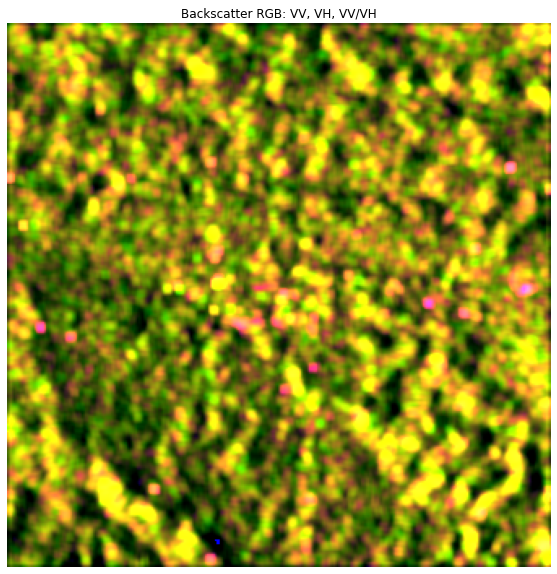

In [ ]:
# RGB Plot of Backscatter Intensity (RGB= VV, VH, VV/VH)
# High backscatter (both bands) due to vegetation and foliage will appear as YELLOW (mix of red and green)
# New vegetation and urban areas are MAGENTA in color (due to high overall scattering and higher VV compared to VH)
# Low vegetation areas are BLUE (due to low overall scattering and higher VV compared to VH)
# Water is BLACK (low backscatter in both bands with similar VV and VH)

rgb(sar_dataset.isel(time=acq_ind_to_show),bands=['vv_amp','vh_amp','vvvh_amp'], width=10)
plt.title('Backscatter RGB: VV, VH, VV/VH')
plt.axis('off')
plt.show()

## Single Date Single-Band Threshold Water Extent
The code below allows users to select a single date (use the index table above), a single band (e.g. VV or VH), and a water detection threshold value for the selected band. Review the histogram plots above to be sure the selected band and threshold are reasonable. It is common to use the VH band for water detection. The final product shows the water in BLUE color against a gray-scale VH-band background image. 

In [ ]:
single_date = 14
single_variable = 'block_filter_vh'
flood_threshold = -21.0

In [ ]:
color_blue = np.array([0,0,255]) # Water (BLUE)
scene = sar_dataset.isel(time=single_date)
water = scene[single_variable].values < flood_threshold

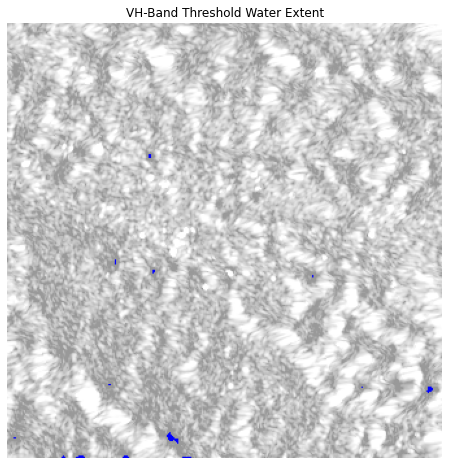

In [ ]:
rgb(scene, bands=['VH', 'VH', 'VH'], 
    paint_on_mask=[(water, color_blue)], width=8, min_inten=0.6)
plt.title('VH-Band Threshold Water Extent')
plt.axis('off')
plt.show()

## Multi-Date Single-Band Threshold Flooding
The code below selects two dates, a variable (VH band) and a threshold range. The final product performs a comparison of the two dates and calculates the change in backscatter between those dates. Pixels with significant reduction in backscatter (e.g., loss of 7 dB) are likely changes from land to water due to flooding.

In [ ]:
# Select TWO acquisitions to calculate a change product
# Choose from the indices in the table above
# first_acq_ind = First time slice acquisition
# second_acq_ind = Second time slice acquisition

first_acq_ind = 10
second_acq_ind = 22

# Select the variable to plot: vv or vh

threshold_variable = 'block_filter_vh'

# The code will calculate the difference of the two images (Second-First)
# Define a threshold range to compare the difference of the two acquisitions
# GREY = Pixels NOT in the threshold range 
# RED = Pixels LESS than the low end of the threshold range
# GREEN = Pixels MORE than the high end of the threshold range

threshold = -7

In [ ]:
# Set the overlay colors
# Calculate the difference in backscatter between the two times
# Find the pixels above or below the threshold range (these are significant changes)

color_loss = np.array([255,0,0]) # backscatter decrease (RED)
color_black = np.array([0,0,0]) # low backscatter change, water (BLACK)
color_blue2 = np.array([0,191,255]) # Water (CYAN)

first_acq = sar_dataset.isel(time=first_acq_ind)
second_acq = sar_dataset.isel(time=second_acq_ind)
change_product = second_acq[threshold_variable] - first_acq[threshold_variable]
below_threshold = change_product.values < threshold

In [ ]:
# Set the water threshold value based on data in the histograms for the selected band
# This will "mask" the water pixels and not show false change

water = first_acq[threshold_variable].values < -21.0

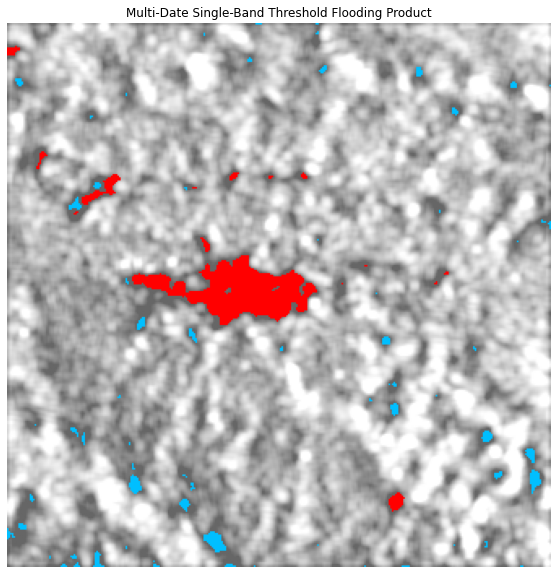

In [ ]:
# Create a custom threshold plot to identify flooding
# The background image VV backscatter (grey-scale)
# RED areas have decreased backscatter indicative of new flooding
# BLACK areas are water in the first acquisition 

rgb(second_acq, bands=['block_filter_vh', 'block_filter_vh', 'block_filter_vh'], 
    paint_on_mask=[(below_threshold, color_loss),(water, color_blue2)], width=10, min_inten=0.4)
plt.title('Multi-Date Single-Band Threshold Flooding Product')
plt.axis('off')
plt.show()